In [2]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input,Conv2D,Conv2DTranspose,MaxPool2D,UpSampling2D,AveragePooling2D,Reshape,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics

In [3]:
def autoencoder(act = 'relu'):
    input_img = Input(shape=(288,288,3), name='input')
    x = input_img
    
    x = Conv2D(64,(7,7),activation=act)(x)
    x = MaxPool2D((3,3))(x)
    
    x = Conv2D(128,(3,3),activation=act)(x)
    x = MaxPool2D((2,2))(x)
    
    x = Conv2D(128,(1,1),activation=act)(x)
    x = Conv2D(128,(3,3),activation=act)(x)
    x = Conv2D(256,(1,1),activation=act)(x)
    x = MaxPool2D((2,2))(x)
    
    x = Conv2D(256,(1,1),activation=act)(x)
    x = Conv2D(256,(3,3),activation=act)(x)
    x = Conv2D(512,(1,1),activation=act)(x)
    x = MaxPool2D((2,2))(x)
    
    x = Conv2D(512,(1,1),activation=act)(x)
    x = Conv2D(512,(3,3),activation=act)(x)
    x = Conv2D(1024,(1,1),activation=act)(x)
    x = AveragePooling2D((8,8))(x)
    x = Flatten()(x)
    encod = x
    
    x = Reshape((-1,1,1024))(x)
    x = UpSampling2D((8,8))(x)
    x = Conv2DTranspose(512,(1,1),activation=act)(x)
    x = Conv2DTranspose(512,(3,3),activation=act)(x)
    x = Conv2DTranspose(256,(1,1),activation=act)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(256,(1,1),activation=act)(x)
    x = Conv2DTranspose(256,(3,3),activation=act)(x)
    x = Conv2DTranspose(128,(1,1),activation=act)(x)
    
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(128,(1,1),activation=act)(x)
    x = Conv2DTranspose(128,(3,3),activation=act)(x)
    x = Conv2DTranspose(64,(1,1),activation=act)(x)
    
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(64,(3,3),activation=act)(x)
    
    x = UpSampling2D((3,3))(x)
    x = Conv2DTranspose(3,(7,7),activation=act)(x)
    
    enc_model = Model(inputs = input_img,outputs = encod)
    dec_model = Model(inputs = input_img,outputs = x)
    return dec_model,enc_model

In [18]:
dec,enc = autoencoder()

In [13]:
image_root =  '/home/sdb1/why/data/YourName_data'
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [23]:
def extract_features(image_root):
    features = []
    for name in os.listdir(image_root):
        filename = os.path.join(image_root,name)
        image = load_img(filename, target_size=(288, 288))
        image = img_to_array(image)/255.0
        features.append(image)
    features = np.array(features)
    return features

In [24]:
features = extract_features(image_root)

In [26]:
dec.compile(optimizer='adam', loss='mse')
dec.fit(features, features, batch_size=32, epochs=100) 

Epoch 1/100
1854/1854 [==============================] - 15s 8ms/step - loss: 0.2619
Epoch 2/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0655
Epoch 3/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0511
Epoch 4/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0474
Epoch 5/100
1854/1854 [==============================] - 14s 7ms/step - loss: 0.0442
Epoch 6/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0432
Epoch 7/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0434
Epoch 8/100
1854/1854 [==============================] - 14s 7ms/step - loss: 0.0423
Epoch 9/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0421
Epoch 10/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0416
Epoch 11/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0420
Epoch 12/100
1854/1854 [==============================] - 13s 7

1854/1854 [==============================] - 13s 7ms/step - loss: 0.0234
Epoch 97/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0223- ET
Epoch 98/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0221
Epoch 99/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0218
Epoch 100/100
1854/1854 [==============================] - 13s 7ms/step - loss: 0.0215


In [44]:
class ClusteringLayer(Layer):

    def __init__(self, n_clusters=10, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        
        self.clusters = self.add_weight(shape = (self.n_clusters, input_dim),initializer='glorot_uniform',name='clusters' )
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [45]:
clustering_layer = ClusteringLayer(10, name='clustering')(enc.output)

In [46]:
model = Model(inputs=enc.input, outputs=clustering_layer)

In [47]:
model.compile(optimizer='adam', loss='kld')

In [42]:
kmeans = KMeans(n_clusters=10, n_init=20)

In [43]:
y_pred = kmeans.fit_predict(enc.predict(features))

In [48]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [53]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [57]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(features.shape[0])
tol = 0.001 # tolerance threshold to stop training
batch_size = 20

In [60]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(features, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        loss = np.round(loss, 5)
        print('Iter loss=', loss)
        # check stop criterion - model convergence
    idx = index_array[index * batch_size: min((index+1) * batch_size, features.shape[0])]
    loss = model.train_on_batch(x=features[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= features.shape[0] else 0

Iter loss= 0.03885
Iter loss= 0.07256
Iter loss= 0.18288
Iter loss= 0.13213
Iter loss= 0.23288
Iter loss= 0.31274
Iter loss= 0.21988
Iter loss= 0.2403
Iter loss= 0.20776
Iter loss= 0.24463
Iter loss= 0.26234
Iter loss= 0.24711
Iter loss= 0.23106
Iter loss= 0.21106
Iter loss= 0.22526
Iter loss= 0.23089
Iter loss= 0.22433
Iter loss= 0.26097
Iter loss= 0.19043
Iter loss= 0.2136
Iter loss= 0.24729
Iter loss= 0.24857
Iter loss= 0.19939
Iter loss= 0.19653
Iter loss= 0.33551
Iter loss= 0.19561
Iter loss= 0.20775
Iter loss= 0.28026
Iter loss= 0.15706
Iter loss= 0.17784
Iter loss= 0.19896
Iter loss= 0.14273
Iter loss= 0.24603
Iter loss= 0.18868
Iter loss= 0.20168
Iter loss= 0.1871
Iter loss= 0.1683
Iter loss= 0.1859
Iter loss= 0.19815
Iter loss= 0.11981
Iter loss= 0.10787
Iter loss= 0.13678
Iter loss= 0.18296
Iter loss= 0.15011
Iter loss= 0.12299
Iter loss= 0.12446
Iter loss= 0.10701
Iter loss= 0.16155
Iter loss= 0.16868
Iter loss= 0.14789
Iter loss= 0.22232
Iter loss= 0.14398
Iter loss= 0.1212

In [66]:
q = model.predict(features, verbose=0)

In [67]:
q = q.argmax(axis=1)

In [68]:
len(q)

1854

In [86]:
q

array([4, 9, 3, ..., 8, 3, 6])

In [87]:
y_pred

array([4, 3, 3, ..., 8, 3, 0], dtype=int32)

In [73]:
from PIL import Image
import matplotlib.pyplot as plt

In [70]:
file_name = os.listdir(image_root)

In [71]:
result = dict(zip(file_name,q))

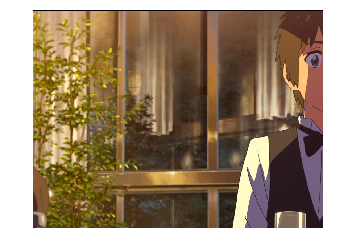

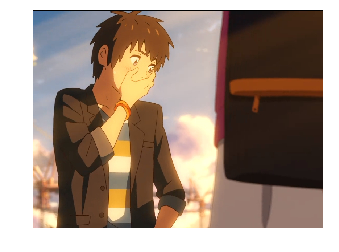

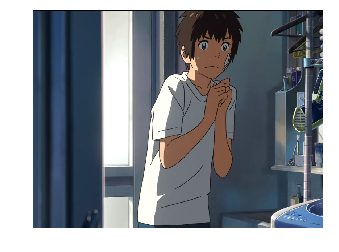

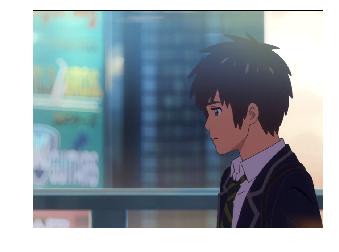

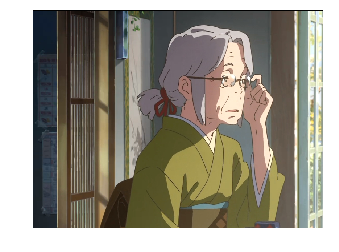

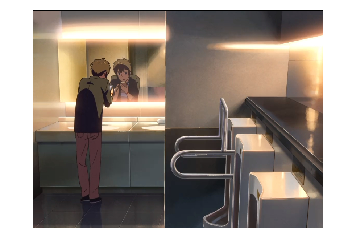

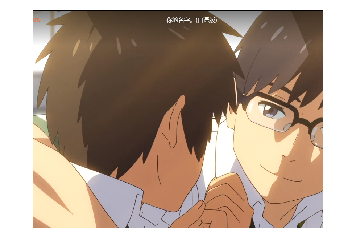

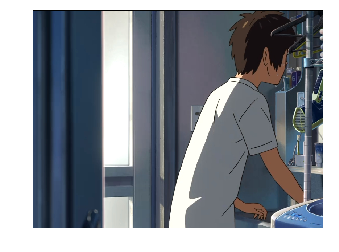

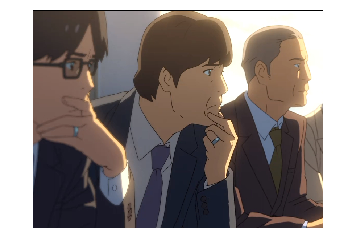

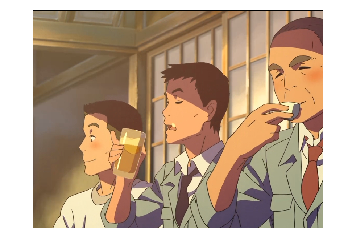

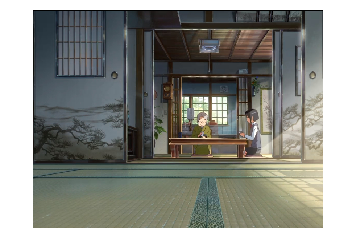

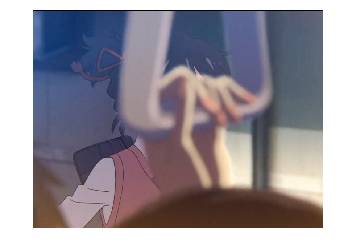

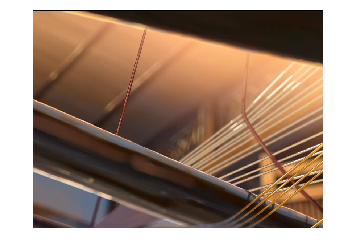

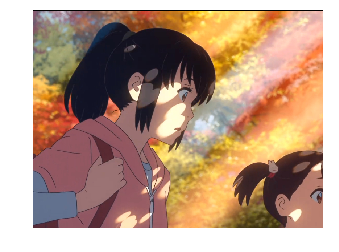

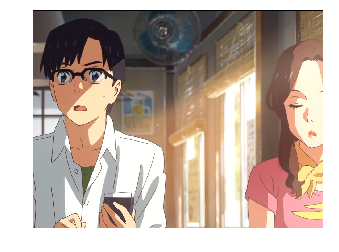

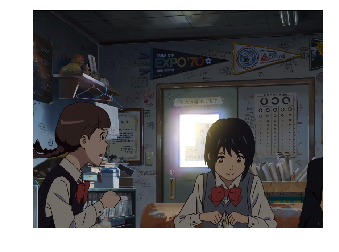

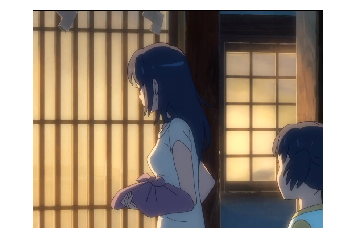

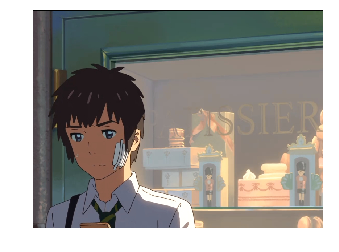

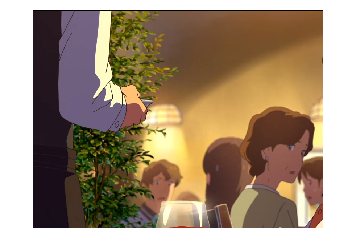

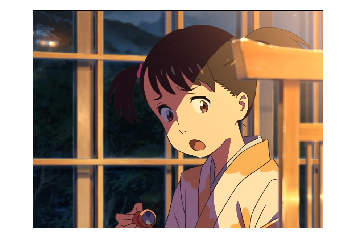

In [90]:
c = 0
for k,v in result.items():
    if v == 3:
        img = Image.open(os.path.join(image_root,str(k)))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        c+=1
    if c == 20:
        break